# Perceptrón multicapa

**Autor:** _Benjamin Torres_

Marzo 2019

En esta práctica implementarás distintos modelos de perceptrón multicapa para clasificar datos haciendo uso de la biblioteca Pytorch.

Puedes encontrar la documentación de esta biblioteca en :
[pytorch.org](https://pytorch.org/docs/stable/index.html)

Escencialmente, PyTorch se encarga de realizar operaciones sobre **tensores**, los cuales pueden crearse haciendo uso de torch.Tensor y pasando como argumento una lista de Python, por ejemplo:

```
import torch
a = torch.Tensor([[1,0,0],[0,1,0],[0,0,1]])
```
Crea una matriz identidad de 3x3.

Podemos ejecutar operaciones con estos tensores de manera similar a como trabajamos con arreglos de Numpy, por ejemplo:

*   Suma, con el método add() o haciendo uso del operador +
*   Producto cruz, con el método dot() o con el operador @
*   Producto entrada por entrada con el operador *
*   Valor máximo, con argmax()
*   Cambio de forma con view( (new shape) )

Entre las ventajas más importantes de hacer uso de esta biblioteca está la capacidad que tiene para realizar **diferenciación automática**, que permite obtener gradientes de expresiones fácilmente, lo cual es especialmente importante en redes neuronales.

In [5]:
import math
import random

import torch
import torch.nn as nn
import torch.optim as optim

import matplotlib.pyplot as plt
#!pip install --force https://github.com/chengs/tqdm/archive/colab.zip
from tqdm import tnrange


Para la implementación de redes neuronales podemos hacer uso de la clase nn.Module.  Ésta se debe extender y se implementa el constructor, así como la manera de hacer *feed forward* con valores de entrada.  Las capas de la red se definen utilizando objetos nn.Linear.

## Ejemplo: Perceptrón simple

En la siguiente celda puedes encontrar un ejemplo de la implementación de un perceptrón que simula la compuerta AND.

In [6]:
class Perceptron(nn.Module):
    def __init__(self, input_size, output_size, bias=True):
      ''' Puedes definir tantos parámetros de entrada como necesites, en este caso únicamente
      el número de elementos de entrada y de salida, observa que debes agregar a self los
      objetos nn.Linear que desees usar, en este caso sólo es uno.
      '''
      super(Perceptron, self).__init__()
      self.fc1 = nn.Linear(in_features = input_size, out_features = output_size, bias=bias)

    def forward(self, inputX):
      '''Debes sobreescibir el método forward, el cual recibe únicamente una entrada:
      los valores sobre los que se evaluará la red.
      Para hacer pasar la entrada a través de una capa, sólo debes llamarla con la entrada
      como parámetro.
      Finalmente puedes notar que se puede aplicar una función de activación a
      todos los valores resultantes.
      Este método debe resultar en, al menos una salida.
      '''
      out = torch.sigmoid(self.fc1(inputX))
      return out

Con la clase implementada ahora sólo es necesario definir la manera en la que se realiza el entrenamiento.

Puedes implementar un método train que reciba los parámetros necesarios, entre los cuales se encuentra:

*   El modelo que se desea entrenar (debe heredar de nn.Module).
*   El número de epocas de entrenamiento.
*   Los datos de entrenamiento (entradas) y sus etiquetas.
*   El criterio de oprimización, es decir, la función de costo, las cuales puedes consultar en [Pytorch loss functions.](https://pytorch.org/docs/stable/nn.html#loss-functions)
*   El método de optimizacion, por ejemplo SGD, distintos algoritmos se encuentran implementados en el modulo [torch.optim](https://pytorch.org/docs/stable/optim.html)

In [9]:
def train(net, epochs, data, labels, criterion, optimizer, cuda=False):
    '''Entrena la red net, por un numero de epocas "epochs",
    usando como función de pérdida la definida en "criterion" y el
    optimizador pasado como parámetro.'''

    avg_loss = torch.Tensor()
    tqdm_epochs = tnrange(epochs)
    for epoch in tqdm_epochs:
        for d,label in zip(data,labels):
            if(cuda and torch.cuda.is_available()): #Si nuestra PC cuenta con GPU,realizamos cálculos en ella
                d = d.cuda()
                label = label.cuda()

            optimizer.zero_grad() #limpiamos los gradientes actuales
            output = net(d)       #llamar a nuestro objeto red con parámetros es introducirlos a la red
            #print("o", output)
            #print("l", label)
            loss   = criterion(output, label) #calculamos el error de nuestro modelo
            loss.backward()       #calculamos el gradiente del error y se almacena dentro del modelo
            optimizer.step()      #usando los datos almacenados y el método seleccionado actualizamos los parámetros de la red

            avg_loss = torch.cat([avg_loss, torch.Tensor([loss])],0)

    tqdm_epochs.set_description("Loss %.6f"%(avg_loss.sum()/avg_loss.numel()).item())

Para nuestro ejemplo podemos tratar el problema de aprender la compuerta AND como un problema de regresión, para lo cual puedes usar la función de error min squared error (MSE), que se encuentra implementada como MSELoss().

Además podemos utilizar descenso por el gradiente, que puedes encontrar en torch.optim.SGD. A este objeto necesitas
pasarle como argumento los parámetros (pesos) del modelo a optimizar, lo cual puedes lograr con el método parameters() de los objetos que heredan de nn.Module; en el caso del descenso por el gradiente tambien debes especificar la taza de aprendizaje.

Puedes ejecutar el entrenamiento sobre el modelo de 2 entradas y una única salida pasándolo como argumento al método train.

In [10]:
# Entradas
X_AND = torch.Tensor([[0,0],
                 [0,1],
                 [1,0],
                 [1,1]])
# Etiquetas
Y_AND = torch.Tensor([0,0,0,1])

Perceptron_AND = Perceptron(2,1)
criterio  = nn.MSELoss()
optimizer = torch.optim.SGD(Perceptron_AND.parameters(), lr=0.1)

train(Perceptron_AND, 10000, X_AND, Y_AND, criterio, optimizer)
#train(Perceptron_AND, 2, X_AND, Y_AND, criterio, optimizer)


<ipython-input-9-579b7526ee89>:7: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  tqdm_epochs = tnrange(epochs)


  0%|          | 0/10000 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Ahora para realizar predicciones con el modelo obtenido unicamente debes pasar los datos como parámetro a la red, la cual ejecutará de manera automática el método forward.
Dado que el problema fue modelado como regresión observarás que los primeros 3 valores son muy cercanos a 0 y el último tiene un valor muy cercano a 1.

In [11]:
resultados = Perceptron_AND(X_AND)
print(resultados)

tensor([[7.4663e-05],
        [3.8159e-02],
        [3.8171e-02],
        [9.5472e-01]], grad_fn=<SigmoidBackward0>)


## Dos perceptrones en una capa

Si quisiéramos resolverlo como un problema de clasificación debemos realizar dos cambios:

*   Cambiar el formato de las etiquetas para que se encuentren en [one-hot](https://en.wikipedia.org/wiki/One-hot).  El primer perceptrón representará al 0 y el segundo, al 1.
*   Usar una función de costo que evalúe el error de clasificación, como la entropía cruzada binaria, implementada en PyTorch como BCELoss().

In [12]:
Y_one_hot = torch.Tensor([[1,0],[1,0],[1,0],[0,1]])
Perceptron_AND_C = Perceptron(2,2)
criterio_clasificacion =  nn.BCELoss()
optimizer = torch.optim.SGD(Perceptron_AND_C.parameters(), lr=0.1)
train(Perceptron_AND_C, 50000, X_AND, Y_one_hot, criterio_clasificacion, optimizer)

<ipython-input-9-579b7526ee89>:7: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  tqdm_epochs = tnrange(epochs)


  0%|          | 0/50000 [00:00<?, ?it/s]

Nota que el resultado será alimentado a la funcion Softmax para que puedas interpretar los resultados como probabilidades.  La salida con el valor más alto es la clase ganadora.

In [13]:
resultados_clasificacion = Perceptron_AND_C(X_AND)
print(nn.functional.softmax(resultados_clasificacion,dim=0))

tensor([[0.2972, 0.1750],
        [0.2966, 0.1753],
        [0.2966, 0.1753],
        [0.1096, 0.4743]], grad_fn=<SoftmaxBackward0>)


## Perceptrón multicapa

### Ejercicio 1: XOR

Haciendo uso de un perceptrón multicapa (MLP, por sus siglas en inglés) crea un modelo capaz de simular la compuerta logica XOR considerandolo un problema de regresión.

Para esta tarea debes usar tres capas:
* La capa de entrada (los valores de entrada a la compuerta)
* Una capa oculta con 3 unidades
* Una capa de salida con una unica neurona

Deberas especificar una **taza de aprendizaje** adecuada así como el número de iteraciones necesario para lograr el aprendizaje.

In [14]:
X_XOR = torch.Tensor([[0,0],
                      [0,1],
                      [1,0],
                      [1,1]])
Y_XOR = torch.Tensor([0,1,1,0])

In [15]:
class XOR(nn.Module):
    def __init__(self):
        super(XOR, self).__init__()
        self.hidden_layer = nn.Linear(2, 3)  # Capa oculta con 2 entradas y 3 salidas
        self.output_layer = nn.Linear(3, 1)  # Capa de salida con 3 entradas y 1 salida

    def forward(self, inputX):
        hidden_output = torch.sigmoid(self.hidden_layer(inputX))  # Aplicar la función sigmoide en la capa oculta
        output = torch.sigmoid(self.output_layer(hidden_output))  # Aplicar la función sigmoide en la capa de salida
        return output

In [16]:
XORNet = XOR()
criterio = nn.MSELoss()  # Error cuadrático medio
optimizer = torch.optim.SGD(XORNet.parameters(), lr=0.1)  # Descenso de gradiente estocástico con tasa de aprendizaje 0.1

train(XORNet, 5000, X_XOR, Y_XOR, criterio, optimizer)

<ipython-input-9-579b7526ee89>:7: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  tqdm_epochs = tnrange(epochs)


  0%|          | 0/5000 [00:00<?, ?it/s]

In [17]:
predicciones = XORNet(X_XOR)
print(predicciones)


tensor([[0.1467],
        [0.8298],
        [0.7922],
        [0.2129]], grad_fn=<SigmoidBackward0>)


### Ejercicio 2:

Encuentra un modelo para clasificar los datos contenidos en Xs y Ys, para lo cual debes encontrar el numero de capas y neuronas adecuado, así como una taza de aprendizaje.

HINT: Puedes utilizar [Playground.tensorflow](https://playground.tensorflow.org) para buscar gráficamente los modelos y al final implementarlos.

In [18]:
def to_learn1(x,y):
    return 1 if x * y >= 0 else -1;

def asignar_color(clase):
    if(clase==1):
        return 'r'
    elif(clase==-1):
        return 'b'

In [19]:
Xs = [random.uniform(-5,5) for _ in range(0,50) ]
Ys = [random.uniform(-5,5) for _ in range(0,50) ]
Zs = [to_learn1(punto[0],punto[1]) for punto in zip(Xs,Ys)]
Colores = [asignar_color(p) for p in Zs]
#print(Xs)
#print(Ys)
#print(Zs)
#print(Colores)

[]

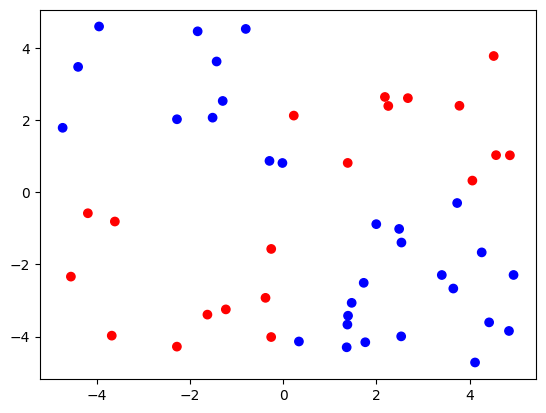

In [20]:
plt.scatter(Xs,Ys,c=Colores)
plt.plot()

In [21]:
#CREA EN ESTA CELDA EL MODELO PARA CLASIFICAR LOS DATOS PROPORCINADOS
class ModeloClasificacion2(nn.Module):
    def __init__(self):
        super(ModeloClasificacion2, self).__init__()
        self.fc1 = nn.Linear(2, 8)  # Capa oculta con 2 entradas y 8 salidas
        self.fc2 = nn.Linear(8, 4)  # Otra capa oculta con 8 entradas y 4 salidas
        self.fc3 = nn.Linear(4, 1)  # Capa de salida con 4 entradas y 1 salida

    def forward(self, inputX):
        hidden1_output = torch.relu(self.fc1(inputX))  # Aplicar ReLU en la primera capa oculta
        hidden2_output = torch.relu(self.fc2(hidden1_output))  # Aplicar ReLU en la segunda capa oculta
        output = torch.sigmoid(self.fc3(hidden2_output))  # Aplicar sigmoide en la capa de salida
        return output

In [22]:
# Define el modelo, criterio y optimizador
modelo = ModeloClasificacion2()
criterio = nn.BCELoss()  # Para clasificación binaria
optimizer = torch.optim.SGD(modelo.parameters(), lr=0.1)

# Reformatea Y_XOR
Y_XOR = Y_XOR.view(-1, 1)

# Entrena el modelo
train(modelo, 5000 , X_XOR, Y_XOR, criterio, optimizer)

<ipython-input-9-579b7526ee89>:7: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  tqdm_epochs = tnrange(epochs)


  0%|          | 0/5000 [00:00<?, ?it/s]

In [23]:
predicciones = modelo(X_XOR)
print(predicciones)

tensor([[3.5770e-05],
        [9.9996e-01],
        [9.9995e-01],
        [2.8023e-05]], grad_fn=<SigmoidBackward0>)


[]

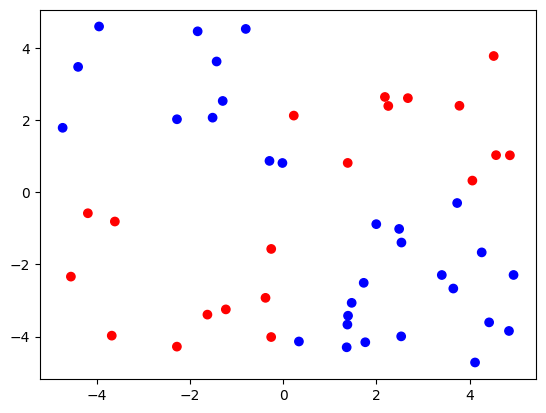

In [24]:
plt.scatter(Xs,Ys,c=Colores)
plt.plot()

### Ejercicio 3:

Encuentra un modelo para clasificar los datos contenidos en X2s y Y2s, para lo cual debes encontrar el numero de capas y neuronas adecuado, así como una taza de aprendizaje.

In [25]:
def to_learn2(deltaT,label):
    n=100
    Xs = []
    Ys = []
    Cs = [label]*n
    for i in range(0,n):
        r = i / n * 20;
        t = 1.3 * i / n * 2 * math.pi + deltaT;
        x = r * math.sin(t) + random.uniform(-1, 1);
        y = r * math.cos(t) + random.uniform(-1, 1);
        Xs.append(x)
        Ys.append(y)
    return Xs,Ys,Cs

def create_data():
    x1,y1,cs1 = to_learn2(0,-1)
    x2,y2,cs2 = to_learn2(math.pi,1)
    x1.extend(x2)
    y1.extend(y2)
    cs1.extend(cs2)
    colores=[asignar_color(p) for p in cs1]
    return x1,y1,cs1,colores

X2s, Y2s,clases,colores= create_data()

[]

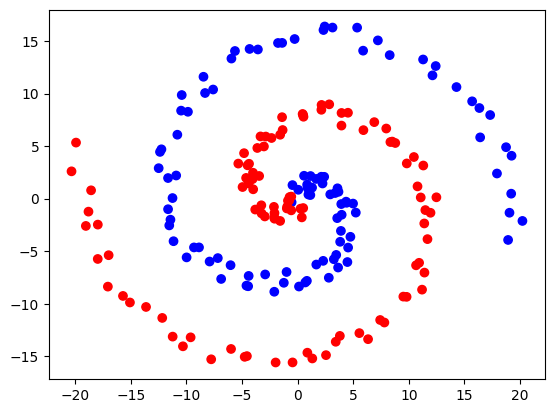

In [26]:
plt.scatter(X2s, Y2s, c=colores)
plt.plot()

In [27]:
#CREA EN ESTA CELDA EL MODELO PARA CLASIFICAR LOS DATOS PROPORCINADOS
class ModeloClasificacion(nn.Module):
    def __init__(self):
        super(ModeloClasificacion, self).__init__()
        self.fc1 = nn.Linear(in_features=2, out_features=32)  # Capa de entrada con 2 neuronas y una capa oculta con 32 neuronas
        self.fc2 = nn.Linear(in_features=32, out_features=1)  # Capa de salida con 1 neurona para clasificación binaria

    def forward(self, inputX):
        x = torch.relu(self.fc1(inputX))  # Aplicar la función de activación ReLU en la capa oculta
        out = torch.sigmoid(self.fc2(x))  # Aplicar la función sigmoide en la capa de salida
        return out

In [28]:
modelo3 = ModeloClasificacion()
criterio = nn.BCELoss()  # Criterio de entropía cruzada binaria
optimizer = torch.optim.SGD(modelo3.parameters(), lr=0.1)  # Optimizador SGD con tasa de aprendizaje 0.1